# Multivariate Time-Series Anomaly Detection for Equipment Sensors

This project demonstrates anomaly detection on multivariate time-series sensor data using both classical machine learning and deep learning approaches.

Models used:
- Isolation Forest
- LSTM Autoencoder

The dataset is unlabeled, so anomalies are evaluated using reconstruction error and visual inspection.


In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Dataset Creation

Synthetic multivariate sensor data is generated to simulate equipment readings.
Artificial anomalies are injected to evaluate anomaly detection models.


In [3]:
np.random.seed(42)

timestamps = pd.date_range("2024-01-01", periods=300, freq="min")

df = pd.DataFrame({
    "timestamp": timestamps,
    "sensor_1": np.random.normal(50, 2, 300),
    "sensor_2": np.random.normal(30, 1.5, 300),
    "sensor_3": np.random.normal(80, 3, 300)
})

# Inject anomalies
df.loc[250:255, "sensor_1"] += 25
df.loc[260:265, "sensor_2"] -= 20
df.loc[270:275, "sensor_3"] += 30

df.to_csv("equipment_sensors.csv", index=False)
df.head()


,timestamp,sensor_1,sensor_2,sensor_3
0,2024-01-01 00:00:00,50.993428,28.756507,82.270966
1,2024-01-01 00:01:00,49.723471,29.159728,77.233504
2,2024-01-01 00:02:00,51.295377,31.120940,82.608818
3,2024-01-01 00:03:00,53.046060,30.915555,84.066914
4,2024-01-01 00:04:00,49.531693,29.968648,81.240305


## Data Loading and Preprocessing


In [4]:
df = pd.read_csv("equipment_sensors.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp")
df.isnull().sum()


timestamp    0
sensor_1     0
sensor_2     0
sensor_3     0
dtype: int64

## Sensor Readings Over Time


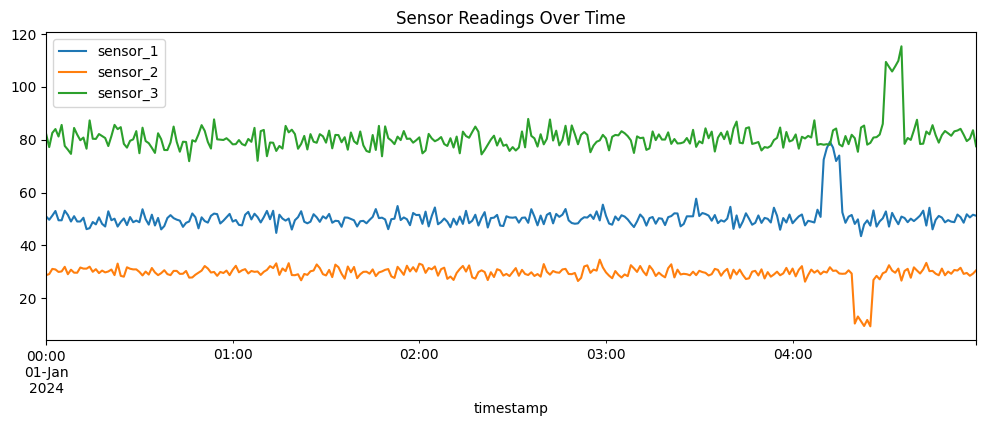

In [5]:
df.set_index("timestamp").plot(figsize=(12,4), title="Sensor Readings Over Time")
plt.show()


## Isolation Forest for Point Anomaly Detection


In [6]:
from sklearn.ensemble import IsolationForest

features = df[["sensor_1", "sensor_2", "sensor_3"]]

iso_model = IsolationForest(contamination=0.05, random_state=42)
df["iso_anomaly"] = iso_model.fit_predict(features)

df[df["iso_anomaly"] == -1].head()


,timestamp,sensor_1,sensor_2,sensor_3,iso_anomaly
251,2024-01-01 04:11:00,76.835724,29.766484,78.333569,-1
252,2024-01-01 04:12:00,79.244312,31.751673,78.087839,-1
253,2024-01-01 04:13:00,77.064931,30.381631,83.567050,-1
254,2024-01-01 04:14:00,71.961260,30.506404,84.261513,-1
255,2024-01-01 04:15:00,74.031532,29.382185,78.287761,-1


## Time-Series Feature Extraction using tsfresh


In [7]:
from tsfresh import extract_features

long_df = df.melt(
    id_vars=["timestamp"],
    value_vars=["sensor_1", "sensor_2", "sensor_3"],
    var_name="sensor",
    value_name="value"
)

long_df["id"] = long_df["sensor"]
long_df["time"] = long_df["timestamp"]

ts_features = extract_features(
    long_df,
    column_id="id",
    column_sort="time",
    column_value="value"
)

ts_features.head()


Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.54s/it]


,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
sensor_1,1.0,0.0,0.0,0.0,15146.670865,7.696564e+05,2.450420,0.000889,0.001516,50.136091,...,0.784589,1.408163,3.418409,1.790225,3.147816,4.544150,5.435517,5.655288,NaN,72.760208
sensor_2,1.0,0.0,0.0,0.0,8870.329508,2.650200e+05,1.722527,0.006052,0.001391,29.920661,...,1.140933,1.807386,3.769981,1.788074,3.148780,4.599028,5.468412,5.648793,NaN,33.387947
sensor_3,1.0,0.0,0.0,0.0,24253.974708,1.968489e+06,3.433999,-0.015792,-0.001733,80.303827,...,1.039730,1.708110,3.675897,1.789883,3.163867,4.557994,5.444915,5.641142,NaN,106.274994


## LSTM Autoencoder for Temporal Anomaly Detection

The LSTM autoencoder learns normal temporal behavior of sensor data.
Anomalies are identified when reconstruction error exceeds a threshold.


In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input


In [9]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)

X = scaled.reshape(scaled.shape[0], 1, scaled.shape[1])
X.shape


(300, 1, 3)

In [10]:
model = Sequential([
    Input(shape=(1, X.shape[2])),
    LSTM(64, activation="relu"),
    RepeatVector(1),
    LSTM(64, activation="relu", return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])

model.compile(optimizer="adam", loss="mse")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 3)                │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,627 (197.76 KB)

 Trainable params: 50,627 (197.76 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(X, X, epochs=20, batch_size=16, verbose=1)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2373
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1944 
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1278
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0483 
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052
Epoch 16/

In [12]:
reconstructions = model.predict(X)
reconstruction_error = np.mean((X - reconstructions) ** 2, axis=(1,2))

threshold = np.percentile(reconstruction_error, 95)
df["lstm_anomaly"] = reconstruction_error > threshold

df[df["lstm_anomaly"] == True].head()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step


,timestamp,sensor_1,sensor_2,sensor_3,iso_anomaly,lstm_anomaly
250,2024-01-01 04:10:00,72.478232,30.129885,78.130578,1,True
251,2024-01-01 04:11:00,76.835724,29.766484,78.333569,-1,True
252,2024-01-01 04:12:00,79.244312,31.751673,78.087839,-1,True
253,2024-01-01 04:13:00,77.064931,30.381631,83.567050,-1,True
255,2024-01-01 04:15:00,74.031532,29.382185,78.287761,-1,True


## LSTM Reconstruction Error


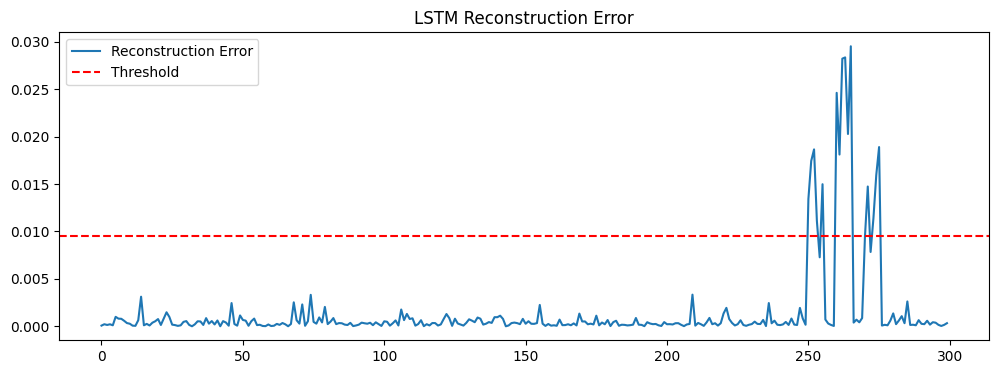

In [13]:
plt.figure(figsize=(12,4))
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("LSTM Reconstruction Error")
plt.show()


## Detected Anomalies on Sensor Data


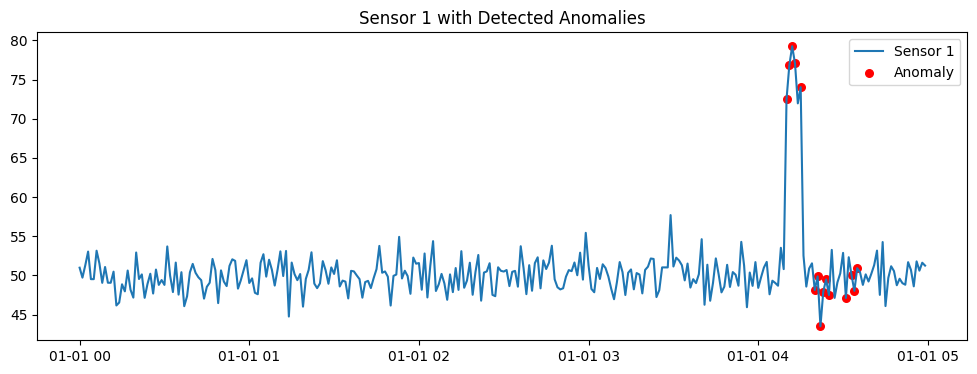

In [14]:
anomalies = df[df["lstm_anomaly"] == True]

plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["sensor_1"], label="Sensor 1")
plt.scatter(anomalies["timestamp"], anomalies["sensor_1"], color="red", label="Anomaly", s=30)
plt.legend()
plt.title("Sensor 1 with Detected Anomalies")
plt.show()


## Model Comparison


In [15]:
comparison = pd.DataFrame({
    "Isolation Forest": df["iso_anomaly"].value_counts(),
    "LSTM Autoencoder": df["lstm_anomaly"].value_counts()
})

comparison


,Isolation Forest,LSTM Autoencoder
-1,15.0,NaN
False,NaN,285.0
1,285.0,15.0


## Evaluation

Since the dataset is unlabeled, traditional metrics such as precision and recall cannot be computed.
Performance is evaluated using reconstruction error distribution and visual inspection.


## Conclusion

Both Isolation Forest and LSTM Autoencoder successfully detected injected anomalies in multivariate sensor data.

- Isolation Forest captured point-wise anomalies.
- LSTM Autoencoder detected temporal deviations using reconstruction error.

This project demonstrates a complete anomaly detection pipeline for equipment sensor monitoring.


## Future Work

- Use sliding window sequences for LSTM input
- Tune model architecture and hyperparameters
- Evaluate on real labeled industrial datasets
- Deploy for real-time anomaly detection
